In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr 

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,r2_score

In [2]:
df = pdr.get_data_yahoo('IBM',start = '2010-01-01' ,end = '2019-01-01')
df['LogClose'] = np.log(df['Close'])
df['DiffLogClose'] = df['LogClose'].diff()


In [3]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [4]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value
series = df['DiffLogClose'].to_numpy()[1:]

T = 21 
X = []
Y = []

for t in range(len(series)-T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)



X.shape (2242, 21) Y.shape (2242,)


In [5]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [6]:
lr = LinearRegression()
lr.fit(Xtrain,Ytrain)
lr.score(Xtrain, Ytrain)

0.009121592050169602

In [7]:
lr.score(Xtest,Ytest)

-0.0997854749322078

In [8]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable

In [9]:
# Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [10]:
# last-Known train value 
last_train = train.iloc[-1]['LogClose']

In [11]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

<AxesSubplot:xlabel='Date'>

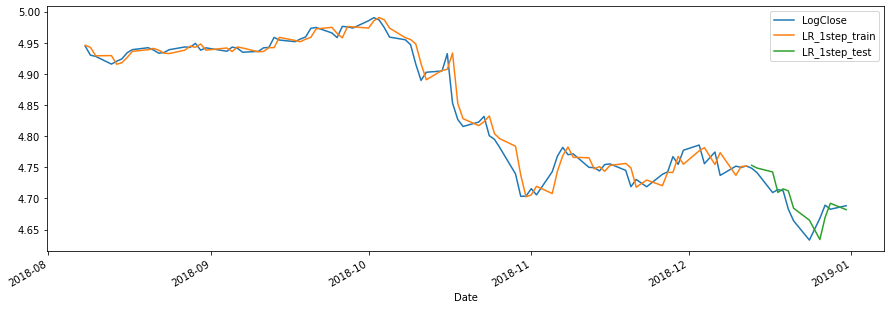

In [12]:
# plot 1-step forecast 
cols = ['LogClose', 'LR_1step_train', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5))

In [13]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
   p = lr.predict(last_x.reshape(1,-1))[0]
    
  # Update the predictions list
   multistep_predictions.append(p)
    
  # make the new input
   last_x = np.roll(last_x, -1)
   last_x[-1] = p 

In [14]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

<AxesSubplot:xlabel='Date'>

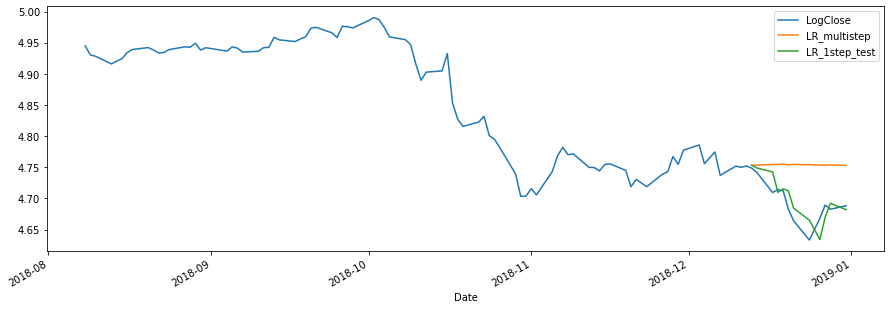

In [15]:
# plot 1-step and multi-step forecast
cols = ['LogClose', 'LR_multistep', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(15,5))

In [16]:
# make multi-output supervised dataset 
Tx = T 
Ty = Ntest
X = []
Y = []
for t in range(len(series)-Tx-Ty+1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2231, 21) Y.shape (2231, 12)


In [17]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [18]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.009975260137645011

In [19]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

-436.4382062000138

In [20]:
# save multi_output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest_m).flatten())

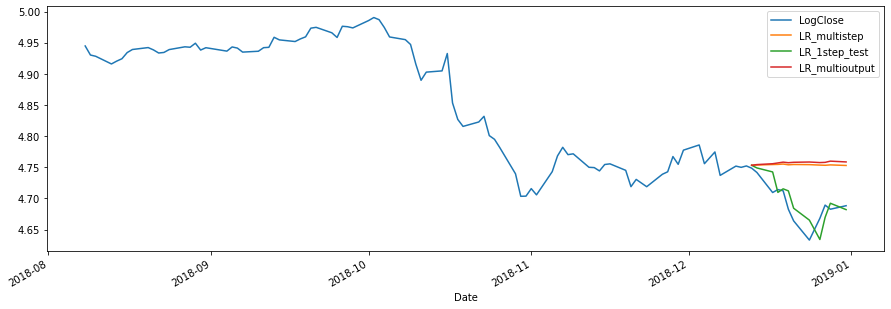

In [21]:
# plot all forecasts
cols = ['LogClose', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df.iloc[-100:][cols].plot(figsize=(15, 5));

In [22]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx,'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_1step_test'])
print("LR_1step_test MAPE:", mape3)

multi-step MAPE: 0.012698585086054667
multi-output MAPE: 0.013391378962689366
LR_1step_test MAPE: 0.003630429998479868


## Test Other Models

In [23]:
def one_step_and_multistep_forecast(model,name):
    model.fit(Xtrain,Ytrain)
    print("One-step forecast:", name)
    # print("Train R^2:" , model.score(Xtrain, Ytrain))
    # print("Test R^2 (1-step):" , model.score(Xtrain, Ytrain))
    
    # store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = \
      prev[train_idx] + model.predict(Xtrain)
    df.loc[test_idx, f'{name}_1step_test'] = \
      prev[test_idx] + model.predict(Xtest)
    
    # store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = \
      last_train + np.cumsum(multistep_predictions)
    
    # Make of multi_step forecast 
    mape = mean_absolute_percentage_error(
        test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
      'LogClose' ,
      f'{name}_1step_train'  ,
      f'{name}_1step_test' ,
      f'{name}_multistep_test'
    ]
        
    df.iloc[-100:][cols].plot(figsize=(15,5))  
    
 
           

One-step forecast: SVR
Test MAPE (multi-step): 0.012698585086054667


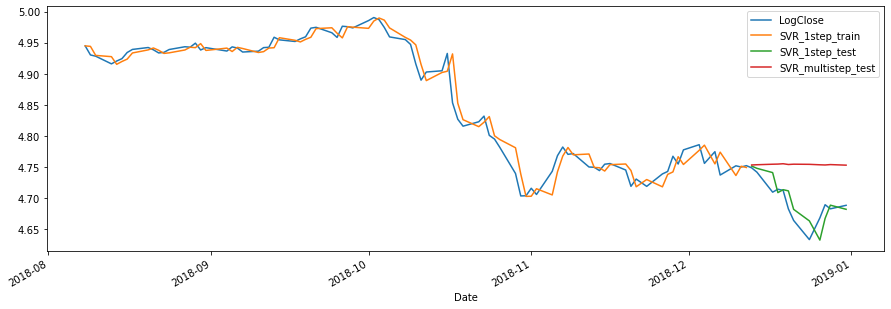

In [24]:
one_step_and_multistep_forecast(SVR(),"SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.012698585086054667


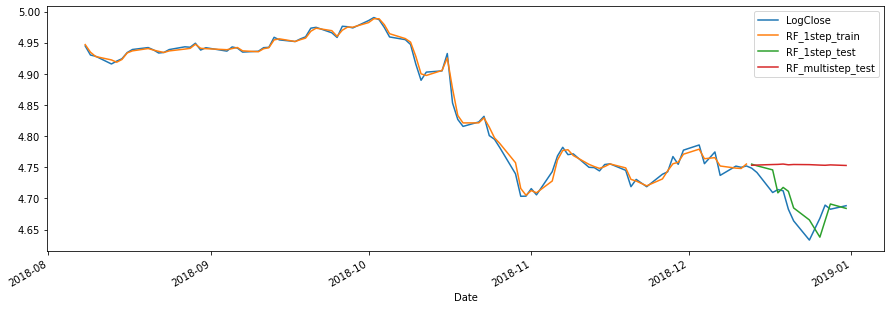

In [25]:
one_step_and_multistep_forecast(RandomForestRegressor(),"RF")

In [26]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m , Ytrain_m)
    
    # save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = \
       last_train + np.cumsum(model.predict(Xtest_m).flatten())
    
    mape = mean_absolute_percentage_error(
        test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi_output):", mape)
 
    # plot all forecasts
    # assume that previous functions have been run
    cols = [
       'LogClose' ,
      f'{name}_1step_train'  ,
      f'{name}_1step_test' ,
      f'{name}_multistep_test',
      f'{name}_multioutput'
    ]
    df.iloc[-100:][cols].plot(figsize=(15,5))

Test MAPE (multi_output): 0.013167197768497433


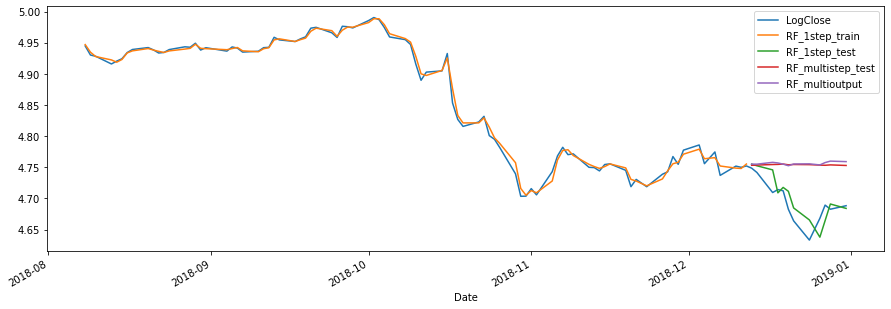

In [27]:
multi_output_forecast(RandomForestRegressor(),"RF")

In [28]:
range(len(series)-T)

range(0, 2242)

In [29]:
x

array([-0.02160125, -0.00049644, -0.00531033,  0.01026331,  0.00106991,
       -0.01041849, -0.02618984,  0.01162164, -0.01170697,  0.02002175,
        0.0039234 ,  0.02444263, -0.01243472,  0.02270699,  0.00833404,
       -0.03005369,  0.01881852, -0.03757888,  0.01488778, -0.00198332,
        0.00223094])

In [30]:
df

,High,Low,Open,Close,Volume,Adj Close,LogClose,DiffLogClose,ShiftLogClose,LR_1step_train,LR_1step_test,LR_multistep,LR_multioutput,SVR_1step_train,SVR_1step_test,SVR_multistep_test,RF_1step_train,RF_1step_test,RF_multistep_test,RF_multioutput
Date,,,,,,,,,,,,,,,,,,,,
2010-01-04,127.122368,125.095604,125.411087,126.625237,6438444.0,82.284233,4.841232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,126.051628,124.378586,125.889099,125.095604,7156104.0,81.290237,4.829078,-0.012154,4.841232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,125.707458,124.101341,124.933075,124.282982,5863144.0,80.762199,4.822561,-0.006517,4.829078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,124.521988,123.240921,124.158699,123.852776,6109268.0,80.482605,4.819094,-0.003468,4.822561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,125.162521,123.374763,123.393883,125.095604,4390271.0,81.290237,4.829078,0.009985,4.819094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,106.118546,102.772469,105.066925,102.839386,3997184.0,85.589706,4.633168,-0.030848,4.664016,NaN,4.665197,4.754248,4.758445,NaN,4.663273,4.754248,NaN,4.665508,4.754248,4.755519
2018-12-26,106.491394,101.281075,103.250481,106.491394,6951507.0,88.629150,4.668064,0.034896,4.633168,NaN,4.634090,4.753506,4.757563,NaN,4.632426,4.753506,NaN,4.637847,4.753506,4.753773
2018-12-27,108.776291,104.655830,105.152962,108.776291,6323698.0,90.530800,4.689293,0.021229,4.668064,NaN,4.669613,4.753215,4.757887,NaN,4.667321,4.753215,NaN,4.664409,4.753215,4.757572
